## 1 . About Dataset
Overview:
This dataset comprises fractured and non-fractured X-ray images covering all anatomical body regions, including lower limb, upper limb, lumbar, hips, knees, etc. The dataset is categorized into train, test, and validation folders, each containing fractured and non-fractured radiographic images. Click this link https://www.kaggle.com/datasets/bmadushanirodrigo/fracture-multi-region-x-ray-data/data to access the dataset.

Dataset Contents:
This dataset contains 10,580 radiographic images (X-ray) data.

Training Data
Number of Images: 9246

Validation Data
Number of Images: 828

Test Data
Number of Images: 506

Author Credits:
Mohan Kumar
Abdelaziz Faramawy
Harsha Arya
Original Datasets:
Mohan Kumar - Bone Break Classifier Dataset
Abdelaziz Faramawy - bone_fracture
Harsha Arya - fracture
Acknowledgment:
I would like to express my gratitude to the following individuals for their contributions to the original datasets used in this combined dataset:

Mohan Kumar for the Bone Break Classifier Dataset
Abdelaziz Faramawy for the bone_fracture dataset
Harsha Arya for the fracture dataset
Links to Original Datasets:
Bone Break Classifier Dataset - https://www.kaggle.com/datasets/amohankumar/bone-break-classifier-dataset
bone_fracture Dataset - https://www.kaggle.com/datasets/abdelazizfaramawy/bone-fracture
fracture Dataset - https://kaggle.com/datasets/harshaarya/fracture
License:
The Fractured X-ray Images dataset is provided under the Open Data Commons Attribution License (ODC-By) v1.0. Users are free to use, share, and modify the dataset, provided proper attribution is given to the dataset creator.

<img src ='https://storage.googleapis.com/kaggle-datasets-images/4854718/8196063/d4f7483de7f808fc08b99c42fa7eba27/dataset-cover.jpg?t=2024-04-22-15-44-02'>

In [2]:
import numpy as np 
import pandas as pd  
from PIL import Image  
import matplotlib  
import matplotlib.pyplot as plt  
import torch  
from torch import nn 
from torch import optim  
import torch.optim as optim  
import torch.nn.functional as F 
from torchvision import transforms, models 
from torch.autograd import Variable  
from torchvision.datasets import ImageFolder 
import torch.utils.data as data 
from torch.utils.data import DataLoader, TensorDataset  
import opendatasets as od

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [4]:
!pip install opendatasets --quiet
import opendatasets as od
dataset_url = "https://www.kaggle.com/datasets/bmadushanirodrigo/fracture-multi-region-x-ray-data"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  skjha69


Your Kaggle Key:

  ································


Dataset URL: https://www.kaggle.com/datasets/bmadushanirodrigo/fracture-multi-region-x-ray-data


100%|██████████| 481M/481M [00:03<00:00, 147MB/s]  


In [5]:
import os
data_dir = '/kaggle/working/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/'
os.listdir(data_dir)

['test', 'train', 'val']

In [6]:
train_dir = data_dir + 'train'
test_dir = data_dir + 'test'
val_dir = data_dir + 'val'

class_names = os.listdir(train_dir)
class_names

['not fractured', 'fractured']

## 2 . Data Augmentation/Cleaning and Image Folder
We can create training and validation datasets using the `ImageFolder` class from `torchvision`. In addition to the `ToTensor` transform, we'll also apply some other transforms to the images. There are a few important changes we'll make while creating PyTorch datasets for training and validation:

1. **Use test set for validation**: Instead of setting aside a fraction (e.g. 10%) of the data from the training set for validation, we'll simply use the test set as our validation set. This just gives a little more data to train with. In general, once you have picked the best model architecture & hypeparameters using a fixed validation set, it is a good idea to retrain the same model on the entire dataset just to give it a small final boost in performance.
2. **Channel-wise data normalization**: We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.

<img src="https://i.imgur.com/LYxXBVg.png" width="360">


3. **Randomized data augmentations**: We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.

![data-augmentation](https://imgaug.readthedocs.io/en/latest/_images/cropandpad_percent.jpg)

In [7]:
from torchvision.datasets import ImageFolder 
from torch.utils.data import DataLoader  
import torchvision.transforms as transforms 
import os  
from PIL import Image 

def identify_and_remove_corrupted_images(dataset_dir:str)->list:
    corrupted_images = []  
    for root, dirs, files in os.walk(dataset_dir):
        for file in files:
            try:
                image_path = os.path.join(root, file)
                with Image.open(image_path) as img:
                    img.load()
            except (IOError, OSError) as e:
                print(f"Corrupted image detected: {image_path}")
                corrupted_images.append(image_path)

    return corrupted_images  

train_dataset_dir = train_dir
val_dataset_dir = val_dir

corrupted_images_train = identify_and_remove_corrupted_images(train_dir)
corrupted_images_val = identify_and_remove_corrupted_images(val_dir)
corrupted_images_test = identify_and_remove_corrupted_images(test_dir)

print(f"Number of corrupted images found in train dataset: {len(corrupted_images_train)}")
print(f"Number of corrupted images found in validation dataset: {len(corrupted_images_val)}")

Corrupted image detected: /kaggle/working/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004148.jpg
Corrupted image detected: /kaggle/working/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004143.jpg
Corrupted image detected: /kaggle/working/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004347.jpg
Corrupted image detected: /kaggle/working/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004134.jpg
Corrupted image detected: /kaggle/working/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004308.jpg
Corrupted image detected: /kaggle/working/fracture-multi-region-x-ray-data/Bone_Fracture_B

In [8]:
from torchvision.transforms import v2

data_transforms = {
    'train': transforms.Compose([
        v2.Resize(size = (224,224)),
        v2.ToTensor(),
        v2.Grayscale(),
    
    ]),  

    'val': transforms.Compose([
        v2.Resize(size = (224,224)),
        v2.ToTensor(),
        # v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomRotation(degrees=7.5),
        v2.RandomAffine(degrees=15, translate=(0.1, 0.1)),
        v2.Grayscale(),
    
    ]) ,
    
     'test': transforms.Compose([
        v2.Resize(size = (224,224)),
        v2.ToTensor(),
        v2.Grayscale(),
    ]) 
    
}

train_data = ImageFolder(root=train_dir,
                            transform=data_transforms['train'],
                            target_transform=None,
                            is_valid_file=None)
    
val_data = ImageFolder(root=val_dataset_dir,
                          transform=data_transforms['val'],
                          target_transform=None,
                          is_valid_file=None)
    
test_data = ImageFolder(root=test_dir,
                          transform=data_transforms['test'],
                          target_transform=None,
                          is_valid_file=None)

train_data.samples = [(img, target) for img, target in train_data.samples if img not in corrupted_images_train]
val_data.samples = [(img, target) for img, target in val_data.samples if img not in corrupted_images_val]
test_data.samples = [(img, target) for img, target in test_data.samples if img not in corrupted_images_test]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


### 2.1 Visualizing  data

In [9]:
class_names = train_data.classes
image , label = train_data[69]
image.shape , label

(torch.Size([1, 224, 224]), 0)

Text(0.5, 1.0, 'fractured : 0')

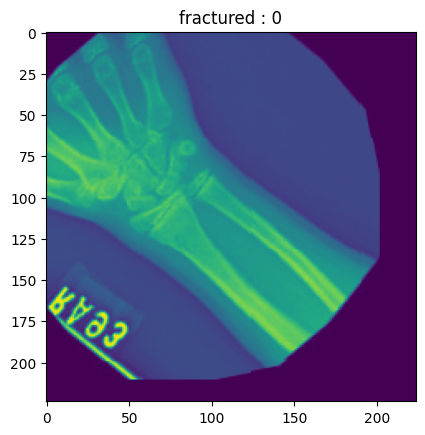

In [10]:
plt.imshow(image.permute(1, 2, 0))
plt.title(f'{class_names[label]} : {label}')

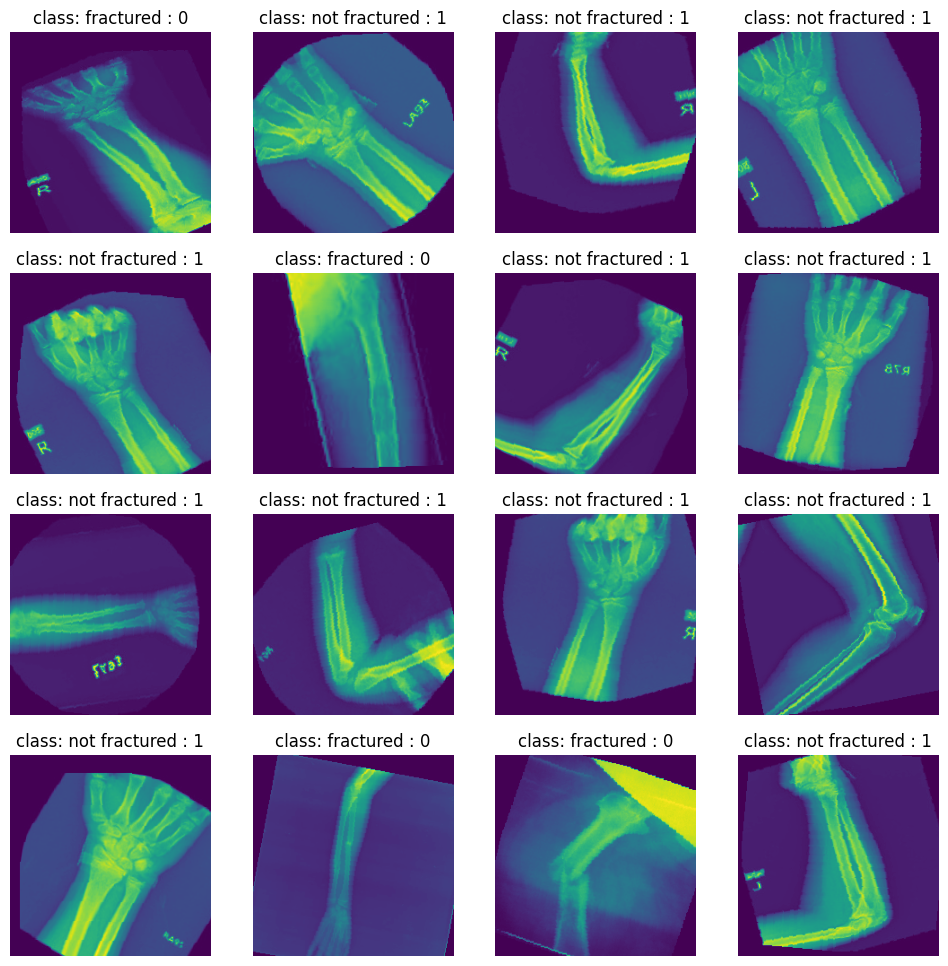

In [11]:
import random
import torch
import matplotlib.pyplot as plt

def plot_random_images(dataset:torch.utils.data.dataset.Dataset ,
                          class_names : list[str] = None,
                          n : int = 3,
                          seed : int = None)->None:
    if seed:
        random.seed(seed)

    fig = plt.figure(figsize=(12, 12))
    for i in range(1,n*n+1):
        random_idx = torch.randint(0 , len(dataset), size = [1]).item()
        image, target = dataset[random_idx]
        fig.add_subplot(n,n,i)
        plt.imshow(image.permute(1,2,0))
        plt.axis(False);
        if class_names:
            title = f"class: {class_names[target]} : {target}"
        else:
            title = None
        plt.title(title)
        
plot_random_images(dataset = val_data, n = 4 , class_names = class_names )

### 2.2 Creating Dataloaders

In [12]:
from torch.utils.data import DataLoader
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32 
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(
    dataset = train_data,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS,
    shuffle = True,
)

val_dataloader = DataLoader(
    dataset = val_data,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS,
    shuffle = False
)

test_dataloader = DataLoader(
    dataset = test_data,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS,
    shuffle = False
)

## 3. Model : Building a Model | ResNet18
ResNet-18, short for Residual Network with 18 layers, is a widely used convolutional neural network (CNN) architecture designed to address the vanishing gradient problem that can occur in deep networks. It was introduced by Kaiming He and his colleagues in the paper "Deep Residual Learning for Image Recognition" in 2015.

### Key Features of ResNet-18:

1. **Residual Learning**:
   - The core idea is the introduction of residual blocks. Each block has a direct connection, or "shortcut," that bypasses one or more layers. This helps in preserving the gradient during backpropagation, thus making it easier to train very deep networks.
   
2. **Architecture**:
   - ResNet-18 consists of 18 layers, including convolutional layers, batch normalization layers, ReLU activations, and fully connected layers. These are organized into a series of residual blocks.
   
3. **Residual Block**:
   - Each residual block contains two 3x3 convolutional layers with batch normalization and ReLU activation, followed by an identity shortcut that adds the input of the block to the output before the final activation.

### Layer Breakdown:
   - **Conv1**: 7x7 convolution with 64 filters, stride 2
   - **MaxPool**: 3x3 max pooling, stride 2
   - **Conv2_x**: 2 residual blocks, each with two 3x3 convolutions (64 filters)
   - **Conv3_x**: 2 residual blocks, each with two 3x3 convolutions (128 filters), with the first block downsampling the feature map via stride 2
   - **Conv4_x**: 2 residual blocks, each with two 3x3 convolutions (256 filters), with the first block downsampling the feature map via stride 2
   - **Conv5_x**: 2 residual blocks, each with two 3x3 convolutions (512 filters), with the first block downsampling the feature map via stride 2
   - **AvgPool**: Global average pooling layer
   - **FC**: Fully connected layer with 1000 output nodes (for ImageNet classification)

### Advantages:
   - **Improved Training**: The residual connections help mitigate the vanishing gradient problem, making it feasible to train deeper networks.
   - **Better Performance**: ResNet-18 has been shown to perform well on various image recognition tasks, providing a good balance between depth and computational efficiency.

### Applications:
   - ResNet-18 is widely used in image classification, object detection, and other computer vision tasks. Its relatively simple and efficient architecture makes it a popular choice for both research and practical applications.

Overall, ResNet-18's architecture is notable for its simplicity and effectiveness in enabling deeper networks to be trained efficiently and accurately.

<img src = 'https://i.imgur.com/XwcnU5x.png' width = '1080' height ='560'>

In [13]:
import torch
import torch.nn as nn

class ResNet18(nn.Module):
    def __init__(self , in_channels = 3,  num_classes = 10):
        super(ResNet18 , self).__init__()

        self.num_classes = num_classes

        self.ConvBlock1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels , out_channels=64 , kernel_size=(7 , 7) , stride=2 , padding=3 , bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2 , inplace=True),
            nn.MaxPool2d(2,2),
        )

        self.ResBlock1 = self._create_residualblock(in_channels=64 , out_channels=64 , stride=1 , padding=1)
        self.ResBlock2 = self._create_residualblock(in_channels=64 , out_channels=64 , stride=1 , padding=1)

        self.ConvBlock2 = self._create_basicblock(in_channels=64 , out_channels=128 , kernel=3 , padding=1 , stride=1)
        self.ResBlock3 = self._create_residualblock(in_channels=128 , out_channels=128 , stride=1 , padding=1)

        self.ConvBlock3 = self._create_basicblock(in_channels=128 , out_channels=256 , kernel=3 , padding=1 , stride=1)
        self.ResBlock4 = self._create_residualblock(in_channels=256 , out_channels=256 , stride=1 , padding=1)

        self.ConvBlock4 = self._create_basicblock(in_channels=256 , out_channels=512 , kernel=3 , padding=1 , stride=1)
        self.ResBlock5 = self._create_residualblock(in_channels=512 , out_channels=512 , stride=1 , padding=1)

        self.avgpool = nn.AvgPool2d(kernel_size=7 , stride=7)

        self.FC = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=512 , out_features=self.num_classes),
        )

    def forward(self, x):
        out = self.ConvBlock1(x)
        out = self.ResBlock1(out) + out
        out = self.ResBlock2(out) + out
        out = self.ConvBlock2(out)
        out = self.ResBlock3(out) + out
        out = self.ConvBlock3(out)
        out = self.ConvBlock4(out)
        out = self.ResBlock5(out) + out
        out = self.avgpool(out)
        out = self.FC(out)
        return out

    def _create_residualblock(self,in_channels , out_channels , stride , padding ):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels , out_channels=out_channels , kernel_size=(3,3) , padding=padding , stride=stride , bias = False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2 , inplace=True),
            nn.Conv2d(in_channels=out_channels , out_channels=out_channels , kernel_size=(3,3) , padding=padding , stride=stride , bias= False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2 , inplace=True),
            )


    def _create_basicblock(self,in_channels , out_channels , kernel,  stride , padding ):
        return nn.Sequential(
                nn.Conv2d(in_channels=in_channels , out_channels=out_channels , kernel_size=kernel , padding=stride , stride =padding , bias =False),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2 , inplace=True),
                nn.MaxPool2d(kernel_size=2 , stride=2),
            )
    
model = ResNet18(in_channels=1,num_classes = len(class_names)).to(device)
model

ResNet18(
  (ConvBlock1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (ResBlock1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (ResBlock2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentu

In [14]:
!pip install torchinfo --q
from torchinfo import summary
summary(model, (1, 1, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet18                                 [1, 2]                    1,180,672
├─Sequential: 1-1                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         3,136
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
│    └─LeakyReLU: 2-3                    [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [1, 64, 56, 56]           --
├─Sequential: 1-2                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-5                       [1, 64, 56, 56]           36,864
│    └─BatchNorm2d: 2-6                  [1, 64, 56, 56]           128
│    └─LeakyReLU: 2-7                    [1, 64, 56, 56]           --
│    └─Conv2d: 2-8                       [1, 64, 56, 56]           36,864
│    └─BatchNorm2d: 2-9                  [1, 64, 56, 56]           128
│    └─LeakyReLU: 2-10                   [1, 64, 56, 56]        

## 4 Functionizing training and test loops

So far we've been writing train and test loops over and over.

Let's write them again but this time we'll put them in functions so they can be called again and again.

And because we're using device-agnostic code now, we'll be sure to call `.to(device)` on our feature (`X`) and target (`y`) tensors.

For the training loop we'll create a function called `train()` which takes in a model, a `DataLoader` a loss function and an optimizer.

The testing loop will be similar but it'll be called `evaluate()` and it'll take in a model, a `DataLoader`, a loss function and an evaluation function.

> **Note:** Since these are functions, you can customize them in any way you like. What we're making here can be considered barebones training and testing functions for our specific classification use case.

In [15]:
def train(model:torch.nn.Module,
          train_loader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          criterion:torch.nn.Module,
          device = device):
    
    # Set the model to training mode
    model.train()

    # Iterate through batches of data in the train_loader
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data and target tensors to the appropriate device (GPU if available, otherwise CPU)
        data, target = data.to(device), target.to(device)

        # Clear the gradients of all optimized variables
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)

        # Calculate the batch loss
        loss =  criterion(output, target)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Perform a single optimization step (parameter update)
        optimizer.step()

In [16]:
def evaluate(model:torch.nn.Module,
              test_loader:torch.utils.data.DataLoader,
              criterion:torch.nn.Module,
              device = device):
    
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables for test loss and correct predictions
    test_loss = 0
    correct = 0

    # Turn off gradients during evaluation
    with torch.no_grad():
        # Iterate through batches of data in the test_loader
        for data, target in test_loader:
            # Move data and target tensors to the appropriate device (GPU if available, otherwise CPU)
            data, target = data.to(device), target.to(device)

            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)

            # Compute the total test loss
            test_loss += criterion(output, target).item()

            # Get the index of the highest probability prediction
            pred = output.max(1, keepdim=True)[1]

            # Count the number of correct predictions
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Calculate the average test loss
    test_loss /= len(test_loader.dataset)

    # Calculate the test accuracy
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

## 5. Creating a `train_model()` function to combine `train()` and `evaluate()`

Now we need a way to put our `train()` and `evaluate()` functions together.

To do so, we'll package them up in a `train_model()` function.

This function will train the model as well as evaluate it.

Specificially, it'll:
1. Take in a model, a `DataLoader` for training and test sets, an optimizer, a loss function and how many epochs to perform each train and test step for.
2. Create an empty results dictionary for `train_loss`, `train_acc`, `test_loss` and `test_acc` values (we can fill this up as training goes on).
3. Loop through the training and test step functions for a number of epochs.
4. Print out what's happening at the end of each epoch.
5. Update the empty results dictionary with the updated metrics each epoch.
6. Return the filled

To keep track of the number of epochs we've been through, let's import `tqdm` from `tqdm.auto` ([`tqdm`](https://github.com/tqdm/tqdm) is one of the most popular progress bar libraries for Python and `tqdm.auto` automatically decides what kind of progress bar is best for your computing environment, e.g. Jupyter Notebook vs. Python script).

In [17]:
import time  
import copy  

results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }

def train_model(model:torch.nn.Module,
                train_loader:torch.utils.data.DataLoader,
                val_loader:torch.utils.data.DataLoader,
                optimizer:torch.optim.Optimizer,
                criterion:torch.nn.Module , 
                num_epochs:int,
                device:torch.device = device):
    
    
    # Lists to store training and validation accuracies and losses for each epoch

    best_acc = 0.0  # Best validation accuracy initialized to 0.0
    best_model_wts = copy.deepcopy(model.state_dict())  # Deep copy of model weights as the best model

    # Loop through each epoch
    for epoch in range(1, num_epochs + 1):
        since = time.time()  # Record the start time of the epoch

        # Train the model for one epoch
        train(model, train_loader, optimizer , criterion)

        # Evaluate the model on the training and validation sets to get loss and accuracy
        train_loss, train_acc = evaluate(model, train_loader , criterion)
        val_loss, val_acc = evaluate(model, val_loader, criterion)

        # Update the best validation accuracy and best model weights if the current validation accuracy is higher
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        # Append current epoch's accuracy and loss values to the lists
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(val_loss)
        results["test_acc"].append(val_acc)

        time_elapsed = time.time() - since  # Calculate time elapsed for the epoch

        # Print epoch statistics
        print('-------------- EPOCH {} ----------------'.format(epoch))
        print('Train Loss: {:.4f}, Accuracy: {:.2f}%'.format(train_loss, train_acc))
        print('Val Loss: {:.4f}, Accuracy: {:.2f}%'.format(val_loss, val_acc))
        print('Time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print()

    # Load the best model weights
    model.load_state_dict(best_model_wts)

    # Return the model with the best weights
    return model

## 6 Train and Evaluate Model 

Alright, alright, alright we've got all of the ingredients we need to train and evaluate our model.

Time to put our `ResNet18` model, `DataLoader`'s and `train()` function together 

To keep our experiments quick, we'll train our model for **25 epochs** 

As for an **optimizer** and **loss function**, we'll use `torch.nn.CrossEntropyLoss()` (since we're working with multi-class classification data) and `torch.optim.Adam()` with a learning rate of `1e-4` respecitvely.

In [18]:
epoch = 25
learning_rate = 0.0001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model = train_model(model, train_dataloader, val_dataloader, optimizer, criterion ,epoch)

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-------------- EPOCH 1 ----------------
Train Loss: 0.0195, Accuracy: 71.82%
Val Loss: 0.0181, Accuracy: 76.31%
Time: 1m 11s



/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-------------- EPOCH 2 ----------------
Train Loss: 0.0154, Accuracy: 82.06%
Val Loss: 0.0225, Accuracy: 75.58%
Time: 1m 12s



/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-------------- EPOCH 3 ----------------
Train Loss: 0.0055, Accuracy: 92.35%
Val Loss: 0.0098, Accuracy: 86.27%
Time: 1m 11s



/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-------------- EPOCH 4 ----------------
Train Loss: 0.0308, Accuracy: 73.41%
Val Loss: 0.0400, Accuracy: 67.92%
Time: 1m 12s



/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-------------- EPOCH 5 ----------------
Train Loss: 0.0034, Accuracy: 96.17%
Val Loss: 0.0083, Accuracy: 91.37%
Time: 1m 12s



/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-------------- EPOCH 6 ----------------
Train Loss: 0.0021, Accuracy: 97.37%
Val Loss: 0.0054, Accuracy: 92.22%
Time: 1m 12s



/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-------------- EPOCH 7 ----------------
Train Loss: 0.0024, Accuracy: 97.35%
Val Loss: 0.0054, Accuracy: 93.92%
Time: 1m 12s



/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-------------- EPOCH 8 ----------------
Train Loss: 0.0153, Accuracy: 85.53%
Val Loss: 0.0229, Accuracy: 77.40%
Time: 1m 11s



/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-------------- EPOCH 9 ----------------
Train Loss: 0.0111, Accuracy: 86.23%
Val Loss: 0.0122, Accuracy: 82.02%
Time: 1m 12s



/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-------------- EPOCH 10 ----------------
Train Loss: 0.0039, Accuracy: 94.90%
Val Loss: 0.0081, Accuracy: 90.64%
Time: 1m 13s



/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-------------- EPOCH 11 ----------------
Train Loss: 0.0043, Accuracy: 93.99%
Val Loss: 0.0068, Accuracy: 90.64%
Time: 1m 11s



/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-------------- EPOCH 12 ----------------
Train Loss: 0.0008, Accuracy: 98.95%
Val Loss: 0.0036, Accuracy: 95.38%
Time: 1m 12s



/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-------------- EPOCH 13 ----------------
Train Loss: 0.0010, Accuracy: 98.69%
Val Loss: 0.0042, Accuracy: 94.17%
Time: 1m 10s



/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-------------- EPOCH 14 ----------------
Train Loss: 0.0030, Accuracy: 96.21%
Val Loss: 0.0079, Accuracy: 90.89%
Time: 1m 11s



/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-------------- EPOCH 15 ----------------
Train Loss: 0.0049, Accuracy: 93.42%
Val Loss: 0.0060, Accuracy: 92.10%
Time: 1m 11s



/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-------------- EPOCH 16 ----------------
Train Loss: 0.0014, Accuracy: 98.07%
Val Loss: 0.0047, Accuracy: 93.44%
Time: 1m 10s



/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-------------- EPOCH 17 ----------------
Train Loss: 0.0006, Accuracy: 99.48%
Val Loss: 0.0042, Accuracy: 95.75%
Time: 1m 10s



/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-------------- EPOCH 18 ----------------
Train Loss: 0.0014, Accuracy: 98.40%
Val Loss: 0.0058, Accuracy: 93.32%
Time: 1m 11s



/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-------------- EPOCH 19 ----------------
Train Loss: 0.0004, Accuracy: 99.61%
Val Loss: 0.0020, Accuracy: 97.69%
Time: 1m 12s



/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-------------- EPOCH 20 ----------------
Train Loss: 0.0014, Accuracy: 98.67%
Val Loss: 0.0036, Accuracy: 95.75%
Time: 1m 11s



/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-------------- EPOCH 21 ----------------
Train Loss: 0.0007, Accuracy: 99.45%
Val Loss: 0.0029, Accuracy: 96.60%
Time: 1m 11s



/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-------------- EPOCH 22 ----------------
Train Loss: 0.0009, Accuracy: 98.80%
Val Loss: 0.0039, Accuracy: 94.78%
Time: 1m 11s



/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-------------- EPOCH 23 ----------------
Train Loss: 0.0003, Accuracy: 99.60%
Val Loss: 0.0023, Accuracy: 96.60%
Time: 1m 11s



/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-------------- EPOCH 24 ----------------
Train Loss: 0.0050, Accuracy: 93.69%
Val Loss: 0.0082, Accuracy: 90.40%
Time: 1m 12s



/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-------------- EPOCH 25 ----------------
Train Loss: 0.0005, Accuracy: 99.52%
Val Loss: 0.0031, Accuracy: 96.48%
Time: 1m 11s



## 7. Plot the loss curves of Model

From the print outs of our `model` training, it didn't look like it did too well.

But we can further evaluate it by plotting the model's **loss curves**. 

**Loss curves** show the model's results over time.

And they're a great way to see how your model performs on different datasets (e.g. training and test).

Let's create a function to plot the values in our `results` dictionary.

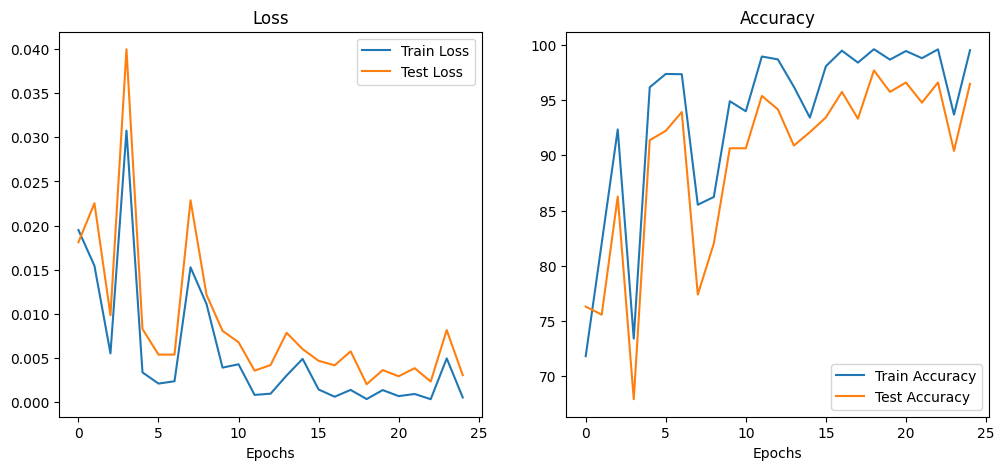

In [19]:
def plot_loss_curves(results: dict[str, list[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, test_loss, label='Test Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Train Accuracy')
    plt.plot(epochs, test_accuracy, label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();
             
plot_loss_curves(results)

### 7.1 Evaluate Model

In [20]:
model.eval()

_, train_acc = evaluate(model, train_dataloader , criterion)

_, val_acc = evaluate(model, val_dataloader , criterion)

_, test_acc = evaluate(model, test_dataloader, criterion)

print('Train Accuracy: {:.4f}%'.format(train_acc))
print('Validation Accuracy: {:.4f}%'.format(val_acc))
print('Test Accuracy: {:.4f}%'.format(test_acc))

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Accuracy: 99.5346%
Validation Accuracy: 97.8129%
Test Accuracy: 97.2000%


## 8. Making Random Prediction on Validation Dataset and Plotting Them

In [27]:
def make_predictions(model: torch.nn.Module,
                     data: list, 
                     device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            
            sample = torch.unsqueeze(sample, dim=0).to(device) 

            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) 
            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(val_data), k=16):
    test_samples.append(sample)
    test_labels.append(label)

pred_probs= make_predictions(model=model,
                             data=test_samples)

pred_classes = pred_probs.argmax(dim=1)
pred_classes

test_labels, pred_classes

([1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1],
 tensor([1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1]))

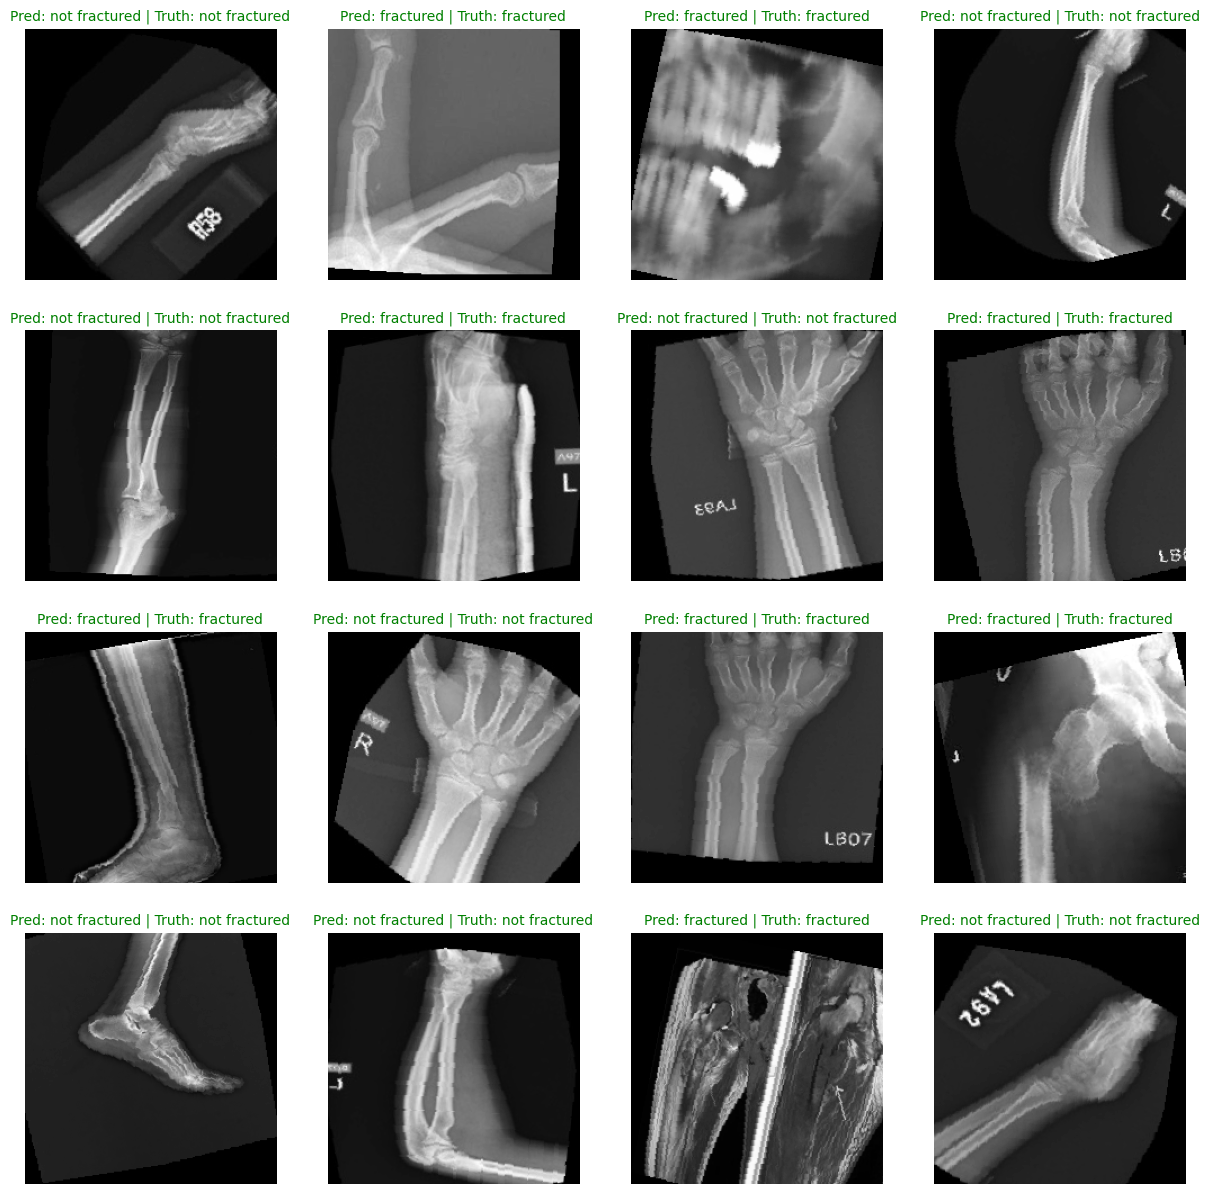

In [28]:
def plot_predicted_images(samples : list ,
                          test_targets : torch.Tensor ,
                          test_preds : torch.Tensor, 
                          class_names : list,
                          rows : int = 4,
                          cols : int = 4):
    
    plt.figure(figsize=(15, 15))
    for i, sample in enumerate(samples):
      plt.subplot(rows, cols, i+1)
      plt.imshow(sample.permute(1,2,0), cmap="gray")
      pred_label = class_names[test_preds[i]]
      truth_label = class_names[test_targets[i]]

      title_text = f"Pred: {pred_label} | Truth: {truth_label}"
      if pred_label == truth_label:
          plt.title(title_text, fontsize=10, c="g") 
      else:
          plt.title(title_text, fontsize=10, c="r") 
      plt.axis(False);
    
plot_predicted_images(test_samples, test_labels , pred_classes , class_names )

In [30]:
def get_preds(model , dataloader , device = device):
    from tqdm.auto import tqdm
    y_preds = []
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(dataloader, desc="Making predictions"):

            X, y = X.to(device), y.to(device)

            y_logit = model(X)

            y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)

            y_preds.append(y_pred.cpu())

    y_pred_tensor = torch.cat(y_preds)
    return y_pred_tensor

val_preds = get_preds(model , val_dataloader)
test_preds = get_preds(model , test_dataloader)

len(val_preds) ,len(test_preds) ,

Making predictions:   0%|          | 0/26 [00:00<?, ?it/s]

Making predictions:   0%|          | 0/16 [00:00<?, ?it/s]

(823, 500)

In [31]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

val_targets = [label for image , label  in val_data]
test_targets = [label for image , label  in test_data]

print(f'Validation Accuarcy : {accuracy_score(val_targets, val_preds)*100}%')
print(f'Test Accuarcy : {accuracy_score(test_targets, test_preds)*100}%')

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Accuarcy : 97.44835965978129%
Test Accuarcy : 97.2%


## 9. Classification Report

In [38]:
from sklearn.metrics import classification_report
print('------------------------------------------------------------')
val_report = classification_report(val_targets, val_preds)
print(f'Classification Report : Validation Dataset')
print(val_report)
print('------------------------------------------------------------')
print()
test_report = classification_report(test_targets, test_preds)
print(f'Classification Report : Test Dataset')
print(test_report)

------------------------------------------------------------
Classification Report : Validation Dataset
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       337
           1       0.98      0.98      0.98       486

    accuracy                           0.97       823
   macro avg       0.97      0.97      0.97       823
weighted avg       0.97      0.97      0.97       823

------------------------------------------------------------

Classification Report : Test Dataset
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       238
           1       0.99      0.95      0.97       262

    accuracy                           0.97       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.97      0.97      0.97       500



## 10. Making a confusion matrix for further prediction evaluation

There are many [different evaluation metrics](https://www.learnpytorch.io/02_pytorch_classification/#9-more-classification-evaluation-metrics) we can use for classification problems.

One of the most visual is a [confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/).

A confusion matrix shows you where your classification model got confused between predicitons and true labels.

To make a confusion matrix, we'll go through three steps:
* Plot the confusion matrix using `scikit-learn` confusion_matrix and `seaborn`.


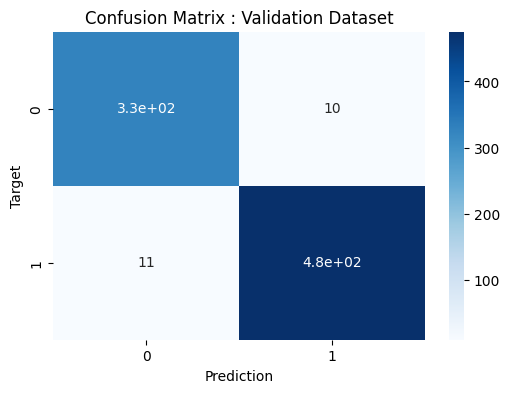

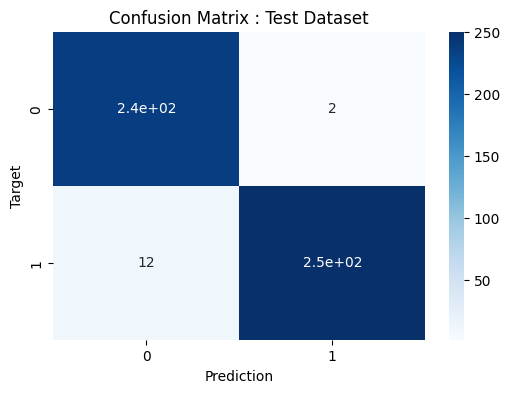

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confusion_matrix(title: str ,targets:torch.Tensor , preds : torch.Tensor):
    cf = confusion_matrix(targets, preds)
    plt.figure(figsize=(6,4))
    sns.heatmap(cf , annot=True , cmap = 'Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title(f'Confusion Matrix : {title}') 
    plt.show()
    
plot_confusion_matrix(title = 'Validation Dataset' ,preds = val_preds , targets = val_targets )
plot_confusion_matrix(title = 'Test Dataset' ,preds = test_preds , targets = test_targets )

## 11. Save and load best performing model

Let's finish this section off by saving and loading in our best performing model.

* `torch.save` - a function to save a whole PyTorch model or a model's `state_dict()`.
* `torch.load` - a function to load in a saved PyTorch object.
* `torch.nn.Module.load_state_dict()` - a function to load a saved `state_dict()` into an existing model instance.

You can see more of these three in the [PyTorch saving and loading models documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

For now, let's save our `model0`'s `state_dict()` then load it back in and evaluate it to make sure the save and load went correctly.

In [63]:
from pathlib import Path

MODEL_PATH = Path("pytorch_saved_model/")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "BoneXRayFractureClassificationResNet18.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),f=MODEL_SAVE_PATH)

Saving model to: pytorch_saved_model/BoneXRayFractureClassificationResNet18.pth


In [64]:
loaded_model = model
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model = loaded_model.to(device)

In [65]:
loaded_model.eval()

_, train_acc = evaluate(loaded_model, train_dataloader , criterion)

_, val_acc = evaluate(loaded_model, val_dataloader , criterion)

_, test_acc = evaluate(loaded_model, test_dataloader, criterion)

print('Train Accuracy: {:.4f}%'.format(train_acc))
print('Validation Accuracy: {:.4f}%'.format(val_acc))
print('Test Accuracy: {:.4f}%'.format(test_acc))

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Accuracy: 99.5563%
Validation Accuracy: 97.3269%
Test Accuracy: 97.2000%
